## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 2s (50.6 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import matplotlib.patches as patches
import random
import cv2

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def get_images(lst, slide, tumor_mask):
  for i in lst:
    slide_path = '/content/drive/My Drive/slide/Copy of tumor_{}.tif'.format(i)
    mask_path = '/content/drive/My Drive/slide/Copy of tumor_{}_mask.tif'.format(i)
    slide_image = open_slide(slide_path)
    mask_image = open_slide(mask_path)
    slide.append(slide_image)
    tumor_mask.append(mask_image)

  return slide, tumor_mask

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))


def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [ ]:
def checkcancer(mask, start, end, off):
  midx = midy = (start + end) // 2

  x_lower, x_upper = midx - off//2, midx + off//2
  y_lower, y_upper = midy - off//2, midy + off//2

  # Check is the 128 X 128 region contain cancer cell
  p = np.sum(mask[x_lower: x_upper, y_lower : y_upper])
 
  return p > 100

In [ ]:
def plot_images(slide_image, mask_image):
    offset = 64
    fig, axes = plt.subplots(1,2, figsize=(7,7))
    midx = midy = 299 // 2
    a = axes[0]
    a.set_title("image")
    a.imshow(slide_image)

    a = axes[1]
    a.set_title('masked image ')
    a.imshow(slide_image)
    a.imshow(mask_image, cmap='jet', alpha=0.5)  
    # plot a 128 X 128 square detect region
    a.plot([midx - offset, midx - offset, midx + offset, midx + offset,midx - offset ],
                [midy - offset, midy + offset, midy + offset, midy - offset, midy - offset], 'g')

In [ ]:
def sliding_windows(picture,  level_num, patch_size, mask_picture):
  # parameters
  downsize_factor =pow(2, level_num)
  True_slide_images, True_slide_mask = [], []
  False_slide_images = []
  tissue_regions = []

  slide = picture
  mask = mask_picture
  offset = 64
  row = slide.level_dimensions[level_num][0]
  col = slide.level_dimensions[level_num][1]
  
  # sliding windows
  for i in range(0, col - patch_size, patch_size):
    y_start = i
 
    
    for j in range(0, row - patch_size, patch_size):
      x_start = j
      #print(x_start, y_start)
      #image slide
      
      slide_image = read_slide(slide, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
    # mask slide
      mask_image = read_slide(mask, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
      # masks used on image
      mask_image_verify = mask_image[:,:,0]

      label = checkcancer(mask_image_verify, 0, 299, 128)

      #collection True data and False data
      if label:
        True_slide_images.append(slide_image)
        True_slide_mask.append(mask_image_verify)
      else:
        False_slide_images.append(slide_image)
        
     


      # visualize
      #plot_images(slide_image, mask_image_verify, level_num )
      # if contain cancer, zoom out and collection image
        

      
  return True_slide_images, False_slide_images, True_slide_mask

# Test Starter Code

In [ ]:
for i in range(len(slides)):
  #print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
  #                                                      slide.level_dimensions[0][0], 
  #    
  #                                                  slide.level_dimensions[0][1]))

  # read slide image
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=6, 
                         width=slides[i].level_dimensions[6][0], 
                         height=slides[i].level_dimensions[6][1])

  plt.figure(figsize=(4,4), dpi=100)
  plt.imshow(slide_image)
  # read mask image

  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=6, 
                        width=slides[i].level_dimensions[6][0], 
                        height=slides[i].level_dimensions[6][1])

  mask_image = mask_image[:,:,0]
  #print(len(sum(mask_image)))
  plt.figure(figsize=(3,3), dpi=100)
  plt.imshow(mask_image)
  # overlay

  mask_image2 = read_slide(tumor_masks[i], 
                        x=250 * 128, 
                        y= 220 * 128, 
                        level=7, 
                        width= 21, 
                        height= 24)
 


  #plt.imshow(slide_image)
  #plt.imshow(mask_image, cmap='jet', alpha=0.5)

  
  tissue_pixels = find_tissue_pixels(slide_image)
  ymintissue = sorted(tissue_pixels, key = lambda x:x[1])
  print(tissue_pixels[0], tissue_pixels[-1])
  print(ymintissue[0], ymintissue[-1])
  #print(tissue_pixels)
  #percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  #print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
  #plt.imshow(tissue_pixels)
  tissue_regions = apply_mask(slide_image, tissue_pixels)
  plt.imshow(tissue_regions)

NameError: ignored

# Collect Data

In [ ]:
True_image = []
False_image = []

8 Training Sets and 2 Validation sets
extracted at level 2, 3, 4, 5, with 
window 299X299

In [ ]:
image_list = ['091','101','078','110'] 
test_list = [ '075']
level_array = [2,3,4,5,6]

Collect Cancer Data and Non Cancer Data at difference level

In [ ]:
slides, tumor_masks = get_images(['084'], [],[])
for i in range(len(slides)):

  True_data, False_data, True_mask = sliding_windows(slides[i], 4, 299, tumor_masks[i])

In [ ]:
#for i in range(len(True_data)):
#  plot_images(True_data[i], True_mask[i])

## Collect data in image '091'

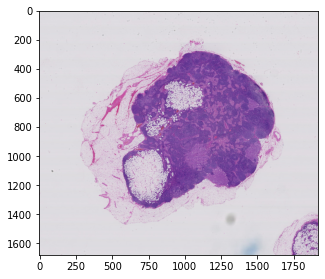

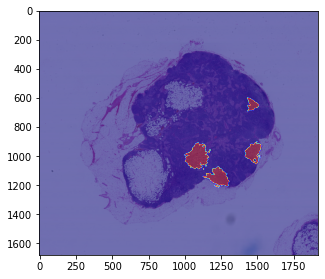

In [ ]:
slides, tumor_masks = get_images(['091'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_91_image = []
False_91_image = []
True_91_mask = []

for i in [0]:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_91_image += True_data 
  False_91_image += False_data
  True_91_mask += True_mask

In [ ]:
print(len(True_91_image))

170


In [ ]:
random.shuffle(True_91_image)
random.shuffle(False_91_image)
Train_true_image, validation_true_image = True_91_image[len(True_91_image)//4 :], True_91_image[: len(True_91_image)//4]
Train_false_image, validation_false_image = False_91_image[:len(False_91_image)//3], False_91_image[len(False_91_image)//3 :]

In [ ]:
print(len(Train_true_image))

128


Plot some data

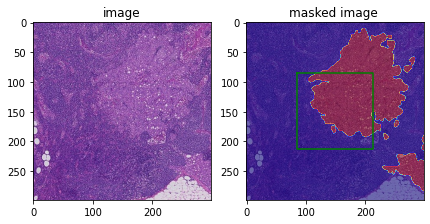

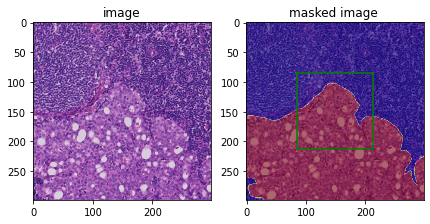

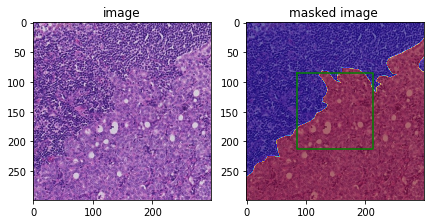

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_91_image) - 1)
  plot_images(True_91_image[n], True_91_mask[n])

In [ ]:
print(len(False_91_image))

694


Save Image

In [ ]:
#for i in range(len(Train_true_image)):
#  True_X_train_filename = '/content/drive/My Drive/Cell/Test/True/image91_{}.png'.format(i)
#  plt.imshow(Train_true_image[i])
#  cv2.imwrite(True_X_train_filename,Train_true_image[i])

In [ ]:
#for i in range(len(validation_true_image)):
##  False_X_train_filename = '/content/drive/My Drive/Cell/Validation/True/image91_{}.png'.format(i)
#  plt.imshow(validation_true_image[i])
#  cv2.imwrite(False_X_train_filename,validation_true_image[i])

## Collect data in image '101'

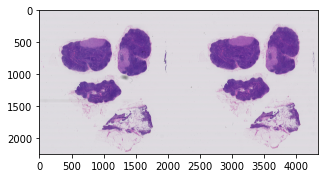

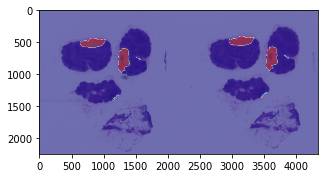

In [ ]:
slides, tumor_masks = get_images(['101'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_101_image = []
False_101_image = []
True_101_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_101_image += True_data 
  False_101_image += False_data
  True_101_mask += True_mask

In [ ]:
random.shuffle(True_101_image)
random.shuffle(False_101_image)
Train_true_image, validation_true_image = True_101_image[len(True_101_image)//4 :], True_101_image[: len(True_101_image)//4]
Train_false_image, validation_false_image = False_101_image[:len(False_101_image)//3], False_101_image[len(False_101_image)//3 :]

Plot some data

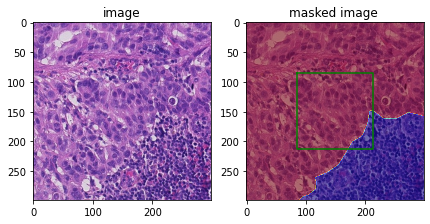

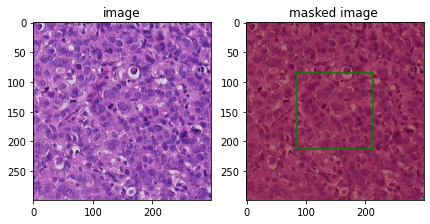

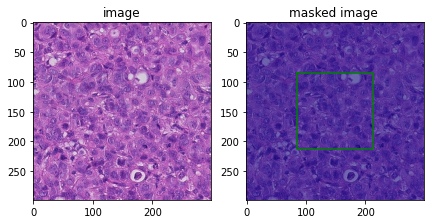

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_101_image) - 1)
  plot_images(True_101_image[n], True_101_mask[n])

In [ ]:
#for i in range(len(Train_true_image)):
  #True_X_train_filename = '/content/drive/My Drive/Cell/Test/True/image101_{}.png'.format(i)
  #plt.imshow(Train_true_image[i])
  #cv2.imwrite(True_X_train_filename,Train_true_image[i])

In [ ]:
#for i in range(len(validation_true_image)):
#  False_X_train_filename = '/content/drive/My Drive/Cell/Validation/True/image101_{}.png'.format(i)
#  plt.imshow(validation_true_image[i])
#  cv2.imwrite(False_X_train_filename,validation_true_image[i])

## Collect data in image '078'

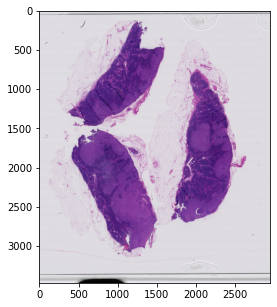

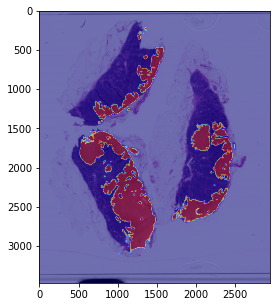

In [ ]:
slides, tumor_masks = get_images(['078'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_078_image = []
False_078_image = []
True_078_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_078_image += True_data 
  False_078_image += False_data
  True_078_mask += True_mask

In [ ]:
print(len(True_078_image))

360


In [ ]:
random.shuffle(True_078_image)
random.shuffle(False_078_image)
Train_true_image, validation_true_image = True_078_image[len(True_078_image)//4 :], True_078_image[: len(True_078_image)//4]
Train_false_image, validation_false_image = False_078_image[:len(False_078_image)//3], False_078_image[len(False_078_image)//3 :]

In [ ]:
print(len(validation_true_image))

90


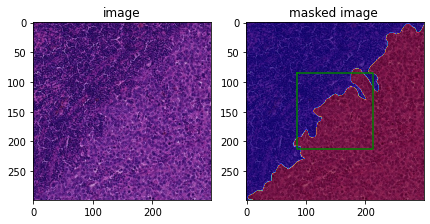

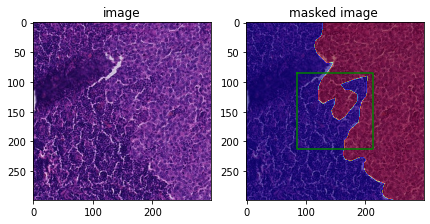

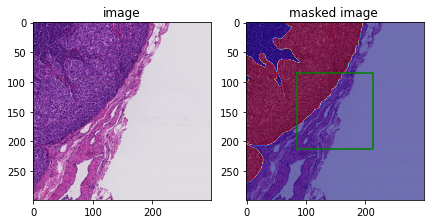

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_078_image) - 1)
  plot_images(True_078_image[n], True_078_mask[n])

In [ ]:
print(len(True_078_image), len(False_078_image))

360 1990


In [ ]:
#for i in range(len(Train_true_image)):
#  True_X_train_filename = '/content/drive/My Drive/Cell/Test/True/image078_{}.png'.format(i)
#  plt.imshow(Train_true_image[i])
#  cv2.imwrite(True_X_train_filename,Train_true_image[i])

In [ ]:
#for i in range(len(validation_true_image)):
##  False_X_train_filename = '/content/drive/My Drive/Cell/Validation/True/image078_{}.png'.format(i)
 # plt.imshow(validation_true_image[i])
 # cv2.imwrite(False_X_train_filename,validation_true_image[i])

## Collect data in image '110'

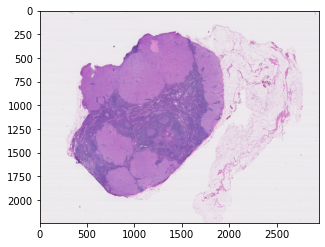

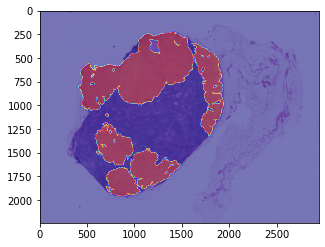

In [ ]:
slides, tumor_masks = get_images(['110'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_110_image = []
False_110_image = []
True_110_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_110_image += True_data 
  False_110_image += False_data
  True_110_mask += True_mask

In [ ]:
print(len(True_110_image))

305


In [ ]:
random.shuffle(True_110_image)
random.shuffle(False_110_image)
Train_true_image, validation_true_image = True_110_image[len(True_110_image)//4 :], True_110_image[ : len(True_110_image)//4]
Train_false_image, validation_false_image = False_110_image[:len(False_110_image)//3], False_110_image[len(False_110_image)//3 :]

In [ ]:
print(len(Train_true_image), len(validation_true_image))

229 76


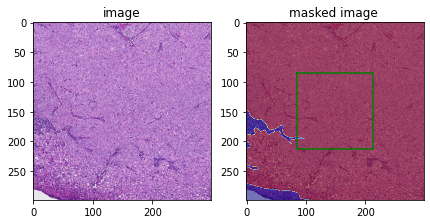

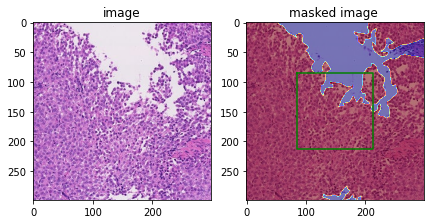

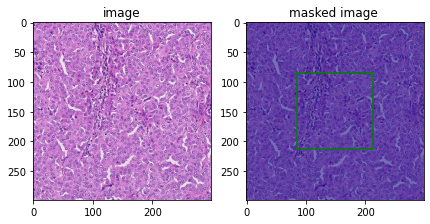

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_110_image) - 1)
  plot_images(True_110_image[n], True_110_mask[n])

In [ ]:
#for i in range(len(Train_true_image)):
#  True_X_train_filename = '/content/drive/My Drive/Cell/Test/True/image110_{}.png'.format(i)
#  plt.imshow(Train_true_image[i])
#  cv2.imwrite(True_X_train_filename,Train_true_image[i])

In [ ]:
print(len(False_110_image))

1167


In [ ]:
#for i in range(len(validation_true_image)):
#  False_X_train_filename = '/content/drive/My Drive/Cell/Validation/True/image110_{}.png'.format(i)
#  plt.imshow(validation_true_image[i])
#  cv2.imwrite(False_X_train_filename,validation_true_image[i])

In [ ]:
Train_True_dir = '/content/drive/My Drive/Cell/Test/True'
#print(len(os.listdir(Train_True_dir)))

In [ ]:
Train_False_dir = '/content/drive/My Drive/Cell/Test/False'
#print(len(os.listdir(Train_False_dir)))

In [ ]:
Valid_True_dir = '/content/drive/My Drive/Cell/Validation/True'
#print(len(os.listdir(Valid_True_dir)))

In [ ]:
Valid_False_dir = '/content/drive/My Drive/Cell/Validation/False'
#print(len(os.listdir(Valid_False_dir)))

## Load Data from Colab

In [ ]:
import os, shutil
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from tensorflow.keras import preprocessing
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
train_dir = '/content/drive/My Drive/Cell/Test'
valid_dir = '/content/drive/My Drive/Cell/Validation'

In [ ]:
markers = ['False', 'True']

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32 ,
    shuffle=True)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(299, 299),
    batch_size=32,
    shuffle=True)

Found 1963 images belonging to 2 classes.
Found 705 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    print(labels_batch)
    break

data batch shape: (32, 299, 299, 3)
labels batch shape: (32, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


# Train Deep Learning Model

In [ ]:
import os, shutil
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(299, 299, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

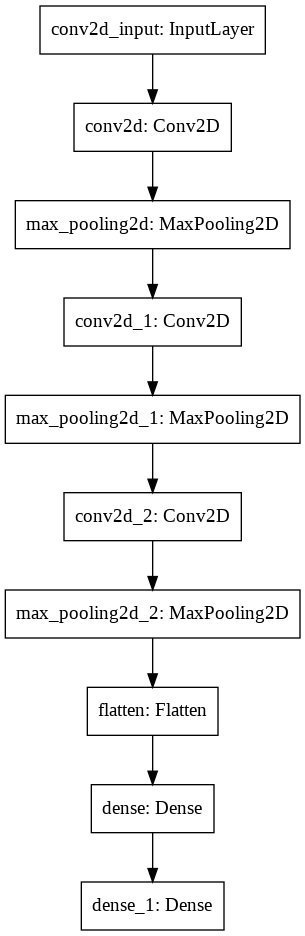

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(
      train_generator,
      epochs=5,
      validation_data = validation_generator)

Epoch 1/5
62/62 [==============================] - 1806s 29s/step - loss: 1.1338 - acc: 0.6780 - val_loss: 0.4663 - val_acc: 0.7603
Epoch 2/5
62/62 [==============================] - 14s 226ms/step - loss: 0.4846 - acc: 0.7504 - val_loss: 0.4139 - val_acc: 0.7787
Epoch 3/5
62/62 [==============================] - 14s 225ms/step - loss: 0.4034 - acc: 0.7764 - val_loss: 0.3121 - val_acc: 0.8567
Epoch 4/5
62/62 [==============================] - 14s 227ms/step - loss: 0.3538 - acc: 0.8334 - val_loss: 0.3340 - val_acc: 0.8340
Epoch 5/5
62/62 [==============================] - 14s 228ms/step - loss: 0.3107 - acc: 0.8645 - val_loss: 0.2332 - val_acc: 0.8950


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 313600)            0

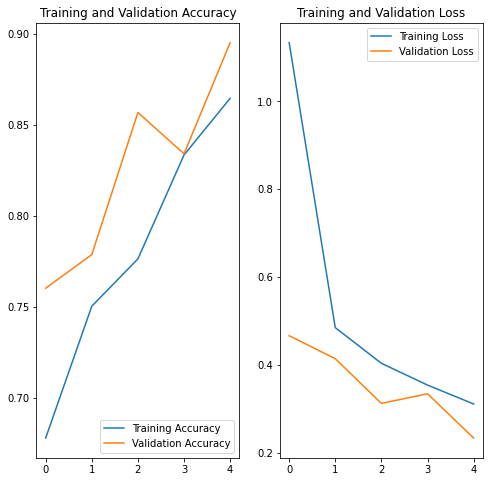

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Create heatmap and Confusion Matrix

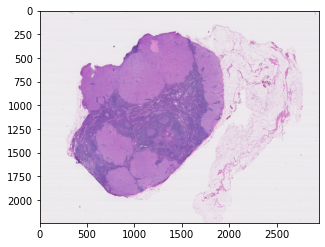

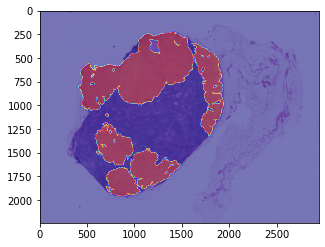

In [ ]:
slides, tumor_masks = get_images(['110'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)


True_110_image = []
False_110_image = []
True_110_mask = []

for i in [3]:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_110_image += True_data 
  False_110_image += False_data
  True_110_mask += True_mask

In [ ]:
predict_true = []
for image in True_110_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_true.append(markers[int(idx)])

predict_false = []
for image in False_110_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_false.append(markers[int(idx)])
  
True_matrix = ['True'] * len(predict_true)
False_matrix = ['False'] * len(predict_false)

In [ ]:
actual = True_matrix + False_matrix
predict = predict_true + predict_false
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(predict, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print('The confusion Matrix is')
print('----------------------------------------')
df_confusion

The confusion Matrix is
----------------------------------------


Predicted,False,True
Actual,,
False,895,19
True,19,198


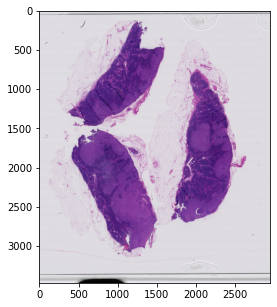

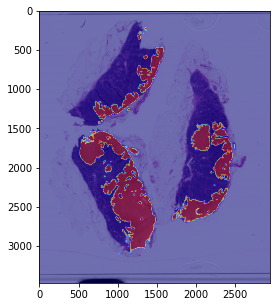

In [ ]:
slides, tumor_masks = get_images(['078'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

True_078_image = []
False_078_image = []
True_078_mask = []

for i in [3]:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_078_image += True_data 
  False_078_image += False_data
  True_078_mask += True_mask

In [ ]:
predict_true = []
for image in True_078_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_true.append(markers[int(idx)])

predict_false = []
for image in False_078_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_false.append(markers[int(idx)])
  
True_matrix = ['True'] * len(predict_true)
False_matrix = ['False'] * len(predict_false)

In [ ]:
actual = True_matrix + False_matrix
predict = predict_true + predict_false
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(predict, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print('The confusion Matrix is')
print('----------------------------------------')
df_confusion

The confusion Matrix is
----------------------------------------


Predicted,False,True
Actual,,
False,1405,140
True,29,220


1. Sliding windows to get samples and labels at different level. 
2. label can be determine the sum of mask matrix i.e. > 0 is cancer < 0 not cancer
3. combine all the data to train the model 

In [ ]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

In [ ]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)